# Tiền xử lý dữ liệu

### Xử lý các giá trị ngoại lai 

Để xử lý việc phân phối dữ liệu của các cột lệch trái (giá trị nhỏ) ta sử dụng phương pháp Xử lý các outliers (Sử dụng IQR)


In [104]:
# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Loại bỏ các outliers cho các cột cần thiết
crypto_data_cleaned = remove_outliers(crypto_data, 'price')
crypto_data_cleaned = remove_outliers(crypto_data_cleaned, 'market_cap')
crypto_data_cleaned = remove_outliers(crypto_data_cleaned, 'total_volume')

# Kiểm tra lại phân phối sau khi loại bỏ outliers
crypto_data_cleaned.describe()


,price,total_volume,market_cap
count,1593.000000,1.593000e+03,1.593000e+03
mean,0.084850,2.567643e+07,1.830220e+09
std,0.044163,2.448024e+07,1.256417e+09
min,0.012120,4.175432e+04,0.000000e+00
25%,0.054457,7.030986e+06,6.234396e+08
50%,0.070734,1.573378e+07,1.622764e+09
75%,0.114462,4.131584e+07,2.779646e+09
max,0.209760,1.097487e+08,5.348032e+09


### Phân phối dữ liệu khi xử lý các giá trị ngoại lai

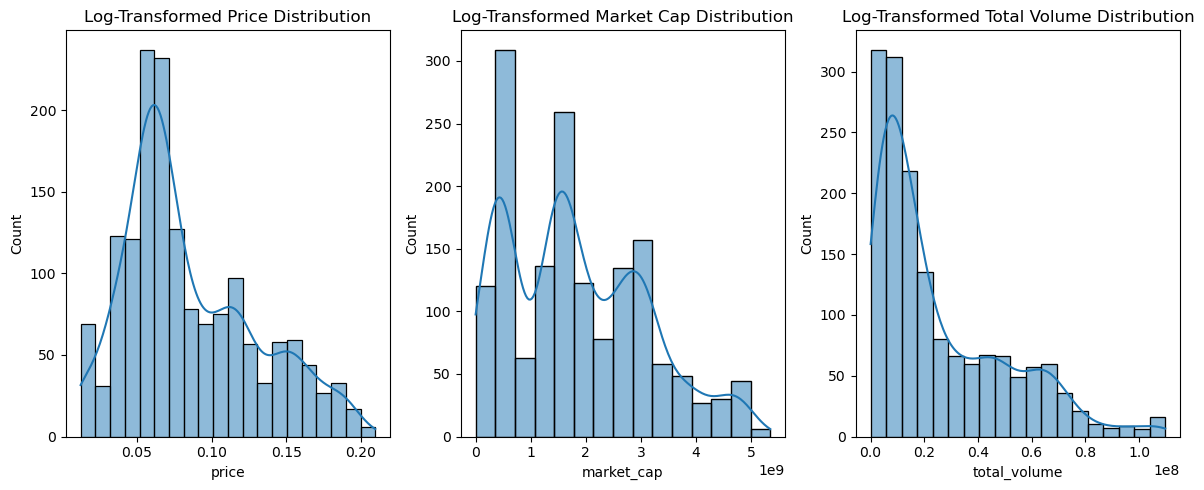

In [105]:
# Kiểm tra phân phối 
plt.figure(figsize=(12, 5))

# Biểu đồ phân phối cho price sau log transformation
plt.subplot(1, 3, 1)
sns.histplot(crypto_data_cleaned['price'], kde=True)
plt.title('Log-Transformed Price Distribution')

# Biểu đồ phân phối cho market_cap sau log transformation
plt.subplot(1, 3, 2)
sns.histplot(crypto_data_cleaned['market_cap'], kde=True)
plt.title('Log-Transformed Market Cap Distribution')

# Biểu đồ phân phối cho total_volume sau log transformation
plt.subplot(1, 3, 3)
sns.histplot(crypto_data_cleaned['total_volume'], kde=True)
plt.title('Log-Transformed Total Volume Distribution')

plt.tight_layout()
plt.show()

Phân phối dữ liệu của cả 3 cột đều được cải thiện hợp lý 

In [106]:
crypto_data_cleaned

,date,price,total_volume,market_cap,coin_name
0,2019-01-02,0.021332,1.990475e+06,0.000000e+00,crypto-com-chain
1,2019-01-03,0.021255,1.968805e+06,0.000000e+00,crypto-com-chain
2,2019-01-04,0.021299,2.399313e+06,0.000000e+00,crypto-com-chain
3,2019-01-05,0.021462,2.393238e+06,0.000000e+00,crypto-com-chain
4,2019-01-06,0.018654,1.833583e+06,0.000000e+00,crypto-com-chain
...,...,...,...,...,...
1907,2024-03-23,0.132821,1.835322e+07,3.530340e+09,crypto-com-chain
1908,2024-03-24,0.137140,1.656765e+07,3.653811e+09,crypto-com-chain
1909,2024-03-25,0.144024,2.489640e+07,3.827381e+09,crypto-com-chain
1910,2024-03-26,0.147626,2.141748e+07,3.915395e+09,crypto-com-chain


### Đánh giá lại mối tương quan giữa các cột 


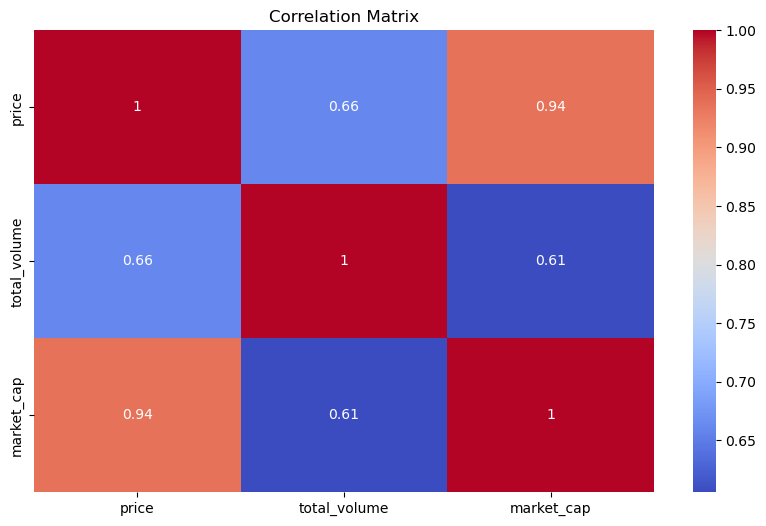

In [107]:
crypto_data_numeric = crypto_data_cleaned.select_dtypes(include=['float64', 'int64'])

# Vẽ biểu đồ tương quan giữa các biến
plt.figure(figsize=(10, 6))
sns.heatmap(crypto_data_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Loại bỏ các cột không cần thiết

In [108]:
crypto_data_cleaned = crypto_data_cleaned.drop(columns='coin_name')
crypto_data_cleaned.head()

,date,price,total_volume,market_cap
0,2019-01-02,0.021332,1.990475e+06,0.0
1,2019-01-03,0.021255,1.968805e+06,0.0
2,2019-01-04,0.021299,2.399313e+06,0.0
3,2019-01-05,0.021462,2.393238e+06,0.0
4,2019-01-06,0.018654,1.833583e+06,0.0


### Lựa chọn các trường

In [109]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Hàm tính VIF cho các biến độc lập
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# Chọn các biến độc lập để kiểm tra VIF
X_vif = crypto_data_cleaned[['total_volume', 'market_cap']]

# Tính toán VIF
vif_data = calculate_vif(X_vif)
print(vif_data)


       Variable       VIF
0  total_volume  3.273231
1    market_cap  3.273231


In [110]:
# Lựa chọn các cột liên quan 
X = crypto_data_cleaned[['total_volume', 'market_cap']]  # Biến độc lập
y = crypto_data_cleaned['price']  # Biến phụ thuộc (Giá)

### Chia dữ liệu

In [111]:
# Chia dữ liệu thành train, validation và test (70%, 15%, 15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Training set: {X_train.shape}, Validation set: {X_validation.shape}, Test set: {X_test.shape}')

Training set: (1115, 2), Validation set: (239, 2), Test set: (239, 2)


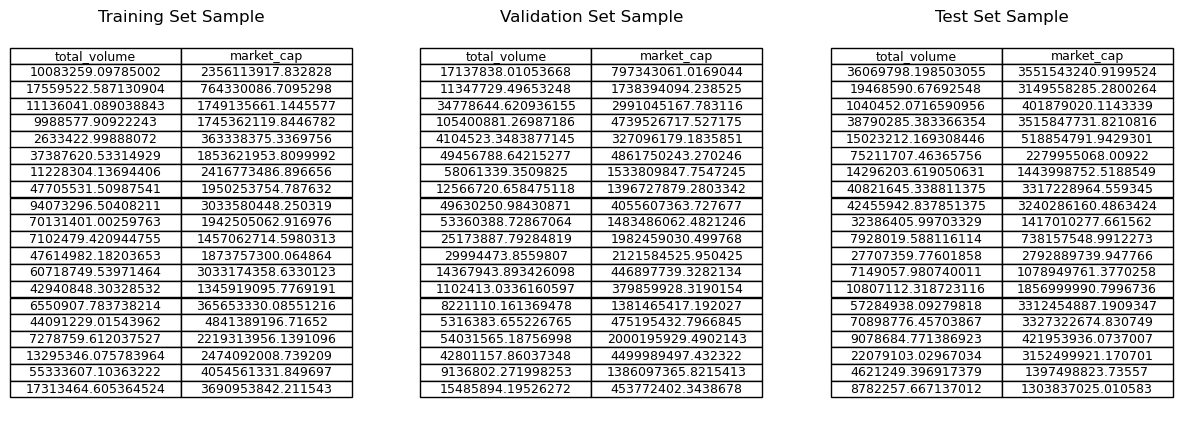

In [112]:
# Hiển thị thông tin về các tập dữ liệu
# Tạo subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Hiển thị dữ liệu của từng tập
axs[0].axis('tight')
axs[0].axis('off')
axs[0].table(cellText=X_train.head(20).values, colLabels=X_train.columns, cellLoc = 'center', loc='center')
axs[0].set_title('Training Set Sample')

axs[1].axis('tight')
axs[1].axis('off')
axs[1].table(cellText=X_validation.head(20).values, colLabels=X_validation.columns, cellLoc = 'center', loc='center')
axs[1].set_title('Validation Set Sample')

axs[2].axis('tight')
axs[2].axis('off')
axs[2].table(cellText=X_test.head(20).values, colLabels=X_test.columns, cellLoc = 'center', loc='center')
axs[2].set_title('Test Set Sample')

plt.show()